# IEEE Fraud Challenge: LightGBM Experiment

By: Michael Mehallow

The goal of this notebook is to apply LightGBM to the IEEE Fraud Challenge dataset and compare results with using sklearn's Gradient Boosted Classifier. The IEEE Fraud Challenge dataset contains data from real-world e-commerce transactions and contains a wide range of features from device type to product features. 

LightGBM is a Gradient Boosting Decision Tree implementation which is designed to be more efficient that the standard algorithm. It achieves its goal through two techniques: Gradient-based One-Side Sampling and Exclusive Feature Bundling. These techniques aim to reduce the number of decision tree split points which need to be evaluated. By reducing the number of evaluations, the implementation results in significantly faster 

Objective measures I will be looking at are training time and model accuracy over a range of iteration numbers. I will also be considering the differences in pre-processing of categorical features as LightGBM can accept categorical features (they do not need to be encoded).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
import lightgbm as lgb

To make the experiment computationally easier, I randomly sampled a subset of the training and test data. The training set contains 177,162 records, and the test set contains 152,007 records, for a combined 329,169 records.

In [71]:
file = open('C:/Users/Michael/Documents/Data-Science/ieee-fraud-detection/medium_train_test.pickle', 'rb')
train, y_train, test = pickle.load(file)

Combine test and train data sets

In [4]:
feature_cols = test.columns
df = pd.concat([train[feature_cols], test[feature_cols]], axis=0).copy()

Retain columns names and indices, but remove original dataframes to save memory.

In [5]:
train_index = train.index
test_index = test.index

train_columns = train.columns
test_columns = test.columns

del train, test

## Feature Engineering / Pre Processing

For this experiment I plan to only do some of the feature engineering I did for my acual submission. I plan to create the most important features from my submission. These are:

- Frequency encode C columns
- Apply target encoding for id_19

As the data will need to be in slightly different formats for each, I will have common processing section, and a model-specific processing section.

**Frequency encode Count Columns**

In [6]:
# Frequency Encode C columns
C_freq_encode_cols = ['C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
num_rows = len(df)

for col in C_freq_encode_cols:
    fq_encode = (df[col].value_counts(dropna=False) / num_rows).to_dict()   
    df[col + '_fq_enc'] = df[col].map(fq_encode)

C_freq_encoded_columns = [ x + '_fq_enc' for x in C_freq_encode_cols]      

df['All_C_fq_enc_sum'] = df[C_freq_encoded_columns].sum(axis=1)

**Target encode id_19**

In [7]:
targets = {}
df['isFraud'] = y_train

for col in ['id_19']:
    targets[col] = df.groupby([col])['isFraud'].mean()
    
df = df.drop(columns={'isFraud'})

df['id_19_target'] = df['id_19'].map(targets['id_19'])

### LightGBM Processing

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
df['ProductCD'] = pd.Categorical(df['ProductCD'])

In [66]:
vesta_columns = [x for x in df.columns if x[0]=='V']

feature_columns = ['TransactionAmt', 'ProductCD', 'All_C_fq_enc_sum', 'id_19_target']
feature_columns.extend(vesta_columns)
feature_columns.extend(C_freq_encoded_columns)

### LightGBM Model
The following section performs preprocessing of the data, creates LightGBM dataset objects, sets model parameters, and trains the model.

In [61]:
# Split test and train parts of dataframe
P_train = df[:len(train_index)]
P_test = df[len(train_index):]

# Downsample negative values to remove class imbalance
positive = P_train[y_train==1].index
negative = P_train[y_train==0].sample(frac=0.04, random_state=1).index

# Combine indicies
downsample_train_idx = positive.append(negative)

# Create new training set
X = P_train.loc[downsample_train_idx].sort_values(by='TransactionID')
y = y_train.loc[X.index]

# Filter Columns
lgb_cols = [x for x in feature_columns if x != 'ProductCD_LE']

# Create cross validation dataset
end_idx = round(len(X)*0.8)
X_train_cv = X[:end_idx][lgb_cols]
y_train_cv = y[:end_idx]
X_cv = X[end_idx:][lgb_cols]
y_cv = y[end_idx:]

# Create Dataset object
train_data = lgb.Dataset(X_train_cv,
                         label=y_train_cv)

# Create Cross Validation Dataset object
cv_data = train_data.create_valid(X_cv,
                                  label=y_cv)

# Set booster parameters
param = {'learning_rate': 0.1,
         'max_depth': 4,
         'feature_fraction': 1,
         'bagging_fraction': 0.8,
         'metric': 'auc',
         'free_raw_data': False}

num_round = 300
start = time.time()
bst = lgb.train(param, train_data, num_round, valid_sets=[cv_data],
                verbose_eval=False)
print('LGBM Training Time : ' + str(time.time()-start))

LGBM Training Time : 4.157716274261475


### LightGBM Evaluation

In [15]:
trial_num_iters = [10, 50, 100, 150, 200, 250, 300] 

param = {'learning_rate': 0.1,
         'max_depth': 4,
         'feature_fraction': 1,
         'bagging_fraction': 0.8,
         'metric': 'auc',
         'free_raw_data': False}

fit_times = {}
cv_auc_scores = {}

for num_iter in trial_num_iters:
    # Create Dataset object
    train_data = lgb.Dataset(X_train_cv,
                             label=y_train_cv)

    # Create Cross Validation Dataset object
    cv_data = train_data.create_valid(X_cv,
                                      label=y_cv)

    start = time.time()
    bst = lgb.train(param, train_data, num_iter, valid_sets=[cv_data],
                    verbose_eval=False)
    fit_times[num_iter] = time.time() - start
    
    # Calculate cv auc               
    y_cv_score = bst.predict(X_cv)
    fpr, tpr, _ = roc_curve(y_cv, y_cv_score)
    cv_auc_scores[num_iter] = auc(fpr, tpr)    

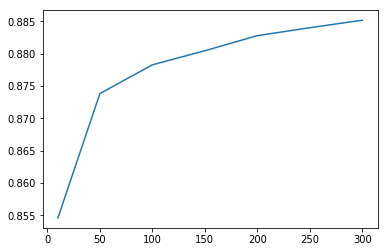

In [16]:
plt.plot(cv_auc_scores.keys(), cv_auc_scores.values())

In [23]:
results = {}

results['LGB'] = {}
results['Sklearn'] = {}

results['LGB']['cv_auc_score'] = cv_auc_scores
results['LGB']['fit_time'] = fit_times

In [30]:
pd.DataFrame(results['LGB'])

,cv_auc_score,fit_time
10,0.854602,0.906478
50,0.873826,1.359190
100,0.878270,1.892909
150,0.880443,2.413611
200,0.882776,3.162181
250,0.884004,3.578925
300,0.885159,4.433450


### Sklearn Processing

In [67]:
enc = df[feature_columns].copy()

# Fill nan values for id_19 target encoding
enc['id_19_target'] = enc['id_19_target'].fillna(0.01)

# Fill nan values for vesta features
vesta_columns = [x for x in enc.columns if x[0]=='V']  
for feature in vesta_columns:
    enc[feature] = enc[feature].fillna(-999)
    
# One Hot Encode ProductCD
enc = pd.get_dummies(enc)

### Sklearn Gradient Boosted Classifier

Model Fit Processing Time : 74.40334701538086


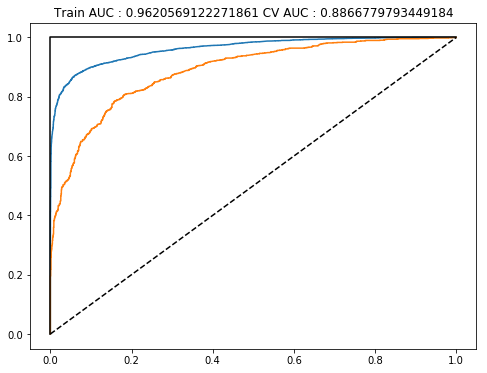

In [32]:
# Split test and train parts of dataframe
P_train = enc[:len(train_index)]
P_test = enc[len(train_index):]

# Downsample negative values
positive = P_train[y_train==1].index
negative = P_train[y_train==0].sample(frac=0.04, random_state=1).index

# Combine indicies
downsample_train_idx = positive.append(negative)

# Create new training set
X = P_train.loc[downsample_train_idx].sort_values(by='TransactionID')
y = y_train.loc[X.index]

# Create cross validation dataset
end_idx = round(len(X)*0.8)
X_train_cv = X[:end_idx]
y_train_cv = y[:end_idx]
X_cv = X[end_idx:]
y_cv = y[end_idx:]

# Define gradient boosting classifier
gbc = GradientBoostingClassifier(max_depth=4,
                                 n_estimators=400,
                                 learning_rate=0.1,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc.fit(X_train_cv, y_train_cv)
print('Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc.predict(X_train_cv)
y_train_score = gbc.predict_proba(X_train_cv)
y_cv_score = gbc.predict_proba(X_cv)

fpr, tpr, _ = roc_curve(y_train_cv, y_train_score[:,1])
train_auc = auc(fpr, tpr)
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(fpr, tpr, label='Train')

fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CV')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('Train AUC : ' + str(train_auc) + ' CV AUC : ' + str(cv_auc))
plt.show()

### Sklearn Evalation

In [33]:
fit_times = {}
cv_auc_scores = {}
                   
for num_iter in trial_num_iters:
    gbc = GradientBoostingClassifier(max_depth=4,
                                     n_estimators=num_iter,
                                     learning_rate=0.1,
                                     subsample=0.9,
                                     max_features='auto')    
    start = time.time()
    gbc.fit(X_train_cv, y_train_cv)
    fit_times[num_iter] = time.time() - start
                   
    # Calculate cv auc               
    y_cv_score = gbc.predict_proba(X_cv)
    fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
    cv_auc_scores[num_iter] = auc(fpr, tpr)

In [35]:
results['Sklearn']['cv_auc_score'] = cv_auc_scores
results['Sklearn']['fit_time'] = fit_times

In [38]:
pd.DataFrame(results['Sklearn'])

,cv_auc_score,fit_time
10,0.857540,2.418607
50,0.875481,11.559324
100,0.879544,20.840897
150,0.883310,29.643064
200,0.886183,43.496537
250,0.887418,67.865612
300,0.886273,82.077396


## Conclusion

In the paper, *LightGBM: A Highly Efficient Gradient Boosting Decision Tree*, the authors claim "LightGBM speeds up the training process of conventional GBDT by up to over 20 times while achieving almost the same accuracy." In our application, we observed that LightGBM was up to 18 times faster than Sklearn GBC. In addition, LightGBM achieved nearly the same accuracy as Sklearn. Sklearn was only 0.15-0.4 % more accurate than LightGBM. 

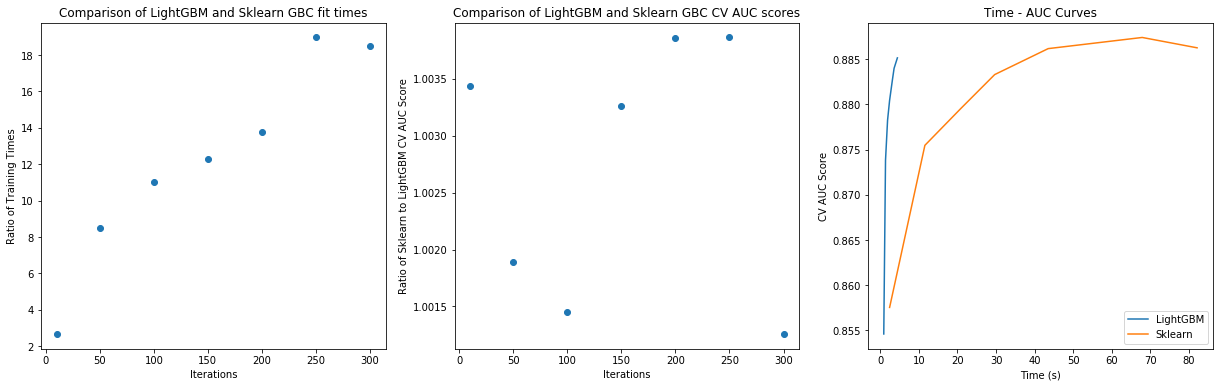

In [89]:
plt.rcParams['figure.figsize'] = 21, 6
plt.subplot(1, 3, 1)
(pd.DataFrame(results['Sklearn'])['fit_time']/pd.DataFrame(results['LGB'])['fit_time']).plot(marker='o', linewidth=0)
plt.xlabel('Iterations')
plt.ylabel('Ratio of Training Times')
plt.title('Comparison of LightGBM and Sklearn GBC fit times')
plt.subplot(1, 3, 2)
(pd.DataFrame(results['Sklearn'])['cv_auc_score']/pd.DataFrame(results['LGB'])['cv_auc_score']).plot(marker='o', linewidth=0)
plt.xlabel('Iterations')
plt.ylabel('Ratio of Sklearn to LightGBM CV AUC Score')
plt.title('Comparison of LightGBM and Sklearn GBC CV AUC scores')
plt.subplot(1, 3, 3)
plt.plot('fit_time', 'cv_auc_score', data=pd.DataFrame(results['LGB']), label='LightGBM')
plt.plot('fit_time', 'cv_auc_score', data=pd.DataFrame(results['Sklearn']), label='Sklearn')
plt.xlabel('Time (s)')
plt.ylabel('CV AUC Score')
plt.legend()
plt.title('Time - AUC Curves')
plt.show()

Below is a list of preprocessing steps used for the two different gradient booseted decision tree implementations.

**LightGBM**
- Convert ProductCD field to categorical

**Sklearn**
- Fill nans for 'id_19_target field'
- Fill nans for Vesta columns
- One hot encode ProductCD field

In terms of data cleansing, LightGBM was easier. I did not have to fill nan values for the id_19_target field or the Vesta columns. In addition, for the Vesta columns I filled them with "-999" which made this step very easy. However a more thorough and manual process of filling values based on attributes of the data would be considerably more time consuming. In the event of going through the manual process, LightGBM would be significantly easier as it does not require filling in na values.

### References

Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu. “LightGBM: A Highly Efficient Gradient Boosting Decision Tree.” Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.

https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf